In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import regex as re

Starting with looking at just the ZEV Sales dataset and copying over the cleaning done from last time.

In [2]:
zev_sales = pd.read_csv('Data/zev_sales.csv')

zev_sales = zev_sales[(zev_sales['Data Year'] <= 2021) & (zev_sales['Data Year'] >= 2009)]

zev_sales.head()

,Data Year,County,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
19,2009,Alameda,Electric,Tesla,Roadster,5
20,2009,Contra Costa,Electric,Tesla,Roadster,1
21,2009,Humboldt,Electric,Ford,Ranger,1
22,2009,Kern,Electric,Tesla,Roadster,1
23,2009,Los Angeles,Electric,MINI,Cooper,6


Let's see how many cars are sold per year, and if that number is increasing.

Data Year
2009      22
2010      47
2011     122
2012     332
2013     520
2014     766
2015     843
2016    1023
2017    1367
2018    1547
2019    1613
2020    1813
2021    2436
Name: Number of Vehicles, dtype: int64

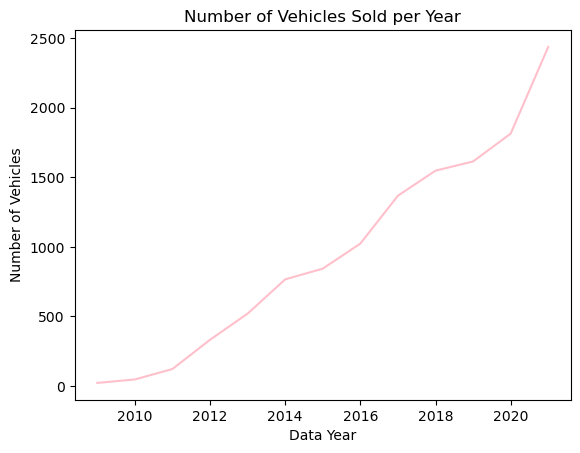

In [3]:
fig1 = sns.lineplot(data = zev_sales.groupby('Data Year').count(), x = 'Data Year', 
                    y = 'Number of Vehicles', color = 'pink');
plt.title('Number of Vehicles Sold per Year');

zev_sales.groupby('Data Year').count()['Number of Vehicles']

In [4]:
zev_sales['Data Year'] = zev_sales['Data Year'].astype(int) #- 2009
zev_sales['Number of Vehicles'] = zev_sales['Number of Vehicles'].astype(int)

print(sm.OLS(zev_sales['Number of Vehicles'], zev_sales['Data Year']).fit().summary())

# see that our coefficient is 0.0420, so that times some year would give us some amount of cars sold that year
# may not keep this however, since i cant find the intercept 
# also this is with the calendar years 2009, 2010, etc. we could also do it as number of years since 2009


                                 OLS Regression Results                                
Dep. Variable:     Number of Vehicles   R-squared (uncentered):                   0.035
Model:                            OLS   Adj. R-squared (uncentered):              0.035
Method:                 Least Squares   F-statistic:                              453.6
Date:                Wed, 31 May 2023   Prob (F-statistic):                    6.80e-99
Time:                        01:25:39   Log-Likelihood:                         -93555.
No. Observations:               12451   AIC:                                  1.871e+05
Df Residuals:                   12450   BIC:                                  1.871e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Which counties have the highest amount of ZEV sales?

Let's also make a bar graph of the number of sales for the top 10 counties. 


,Data Year,FUEL_TYPE,MAKE,MODEL,Number of Vehicles
County,,,,,
Los Angeles,457,457,457,457,457
Orange,437,437,437,437,437
San Diego,408,408,408,408,408
Santa Clara,399,399,399,399,399
Alameda,390,390,390,390,390
Contra Costa,384,384,384,384,384
San Mateo,383,383,383,383,383
San Francisco,372,372,372,372,372
Riverside,372,372,372,372,372


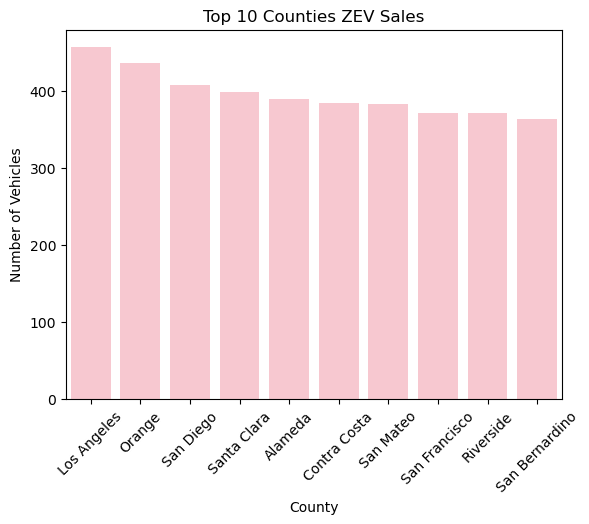

In [5]:
fig2 = sns.barplot(data = zev_sales.groupby('County').count().sort_values(by = 'Number of Vehicles', 
                ascending = False).head(10).reset_index(), x = 'County', y = 'Number of Vehicles', color = 'pink')
plt.xticks(rotation=45)
plt.title('Top 10 Counties ZEV Sales')

zev_sales.groupby('County').count().sort_values(by = 'Number of Vehicles', ascending = False).head(10)


What is the total number of sales per year? (i.e. if one car is sold year one, and two are sold year two, the total number of sales per year for year two would be three.)

In [6]:
by_year = zev_sales.groupby('Data Year').sum()

count_per_year = by_year['Number of Vehicles'].values

cumulative = []

for i in range(len(count_per_year)):
    cumulative.append(sum(count_per_year[0:i + 1]))
    
    
by_year['Cumulative Sales'] = cumulative

print('The total number of ZEVs sold between 2009 and 2021 is ' + str(sum(count_per_year)))

by_year

# zev_sales.groupby(['County', 'Data Year']).sum()

The total number of ZEVs sold between 2009 and 2021 is 1054067


,Number of Vehicles,Cumulative Sales
Data Year,,
2009,84,84
2010,661,745
2011,6743,7488
2012,17839,25327
2013,39805,65132
2014,58663,123795
2015,64134,187929
2016,72683,260612
2017,93587,354199


We can now look at ZEV sales as a percentage of cars registered by county. We will perform the same data cleaning steps but only on the 2021 registration data.

In [7]:
reg_2021 = pd.read_csv('Data/Vehicles Registered By County-2021.csv', encoding='utf-16')
reg_2021 = reg_2021.dropna().iloc[0:59].drop(columns=['Trailers', 'Motorcycles'])
reg_2021['Total Vehicles'] = reg_2021['Autos'] + reg_2021['Trucks']


Now we prepare to merge datasets.

In [8]:
reg_2021['Counties'] = reg_2021['Counties'].apply(str.lower)
reg_2021.sort_values(by = 'Counties', inplace = True)

by_county = zev_sales.groupby('County').sum().sort_values(by = 'County').reset_index()
by_county['County'] = by_county['County'].apply(str.lower)

merged = reg_2021.merge(by_county, left_on = 'Counties', right_on = 'County').drop(['County', 
                        'Data Year', 'Trucks', 'Total Vehicles'], axis = 1)

merged = merged.rename(columns = {'Counties': 'County', 'Number of Vehicles': 'Number of ZEVs'})

merged['Percentage ZEV'] = (merged['Number of ZEVs'] * 100) / merged['Autos']

sort_by_percent = merged.sort_values(by = 'Percentage ZEV', ascending = False)

sort_by_percent.head()

,County,Autos,Number of ZEVs,Percentage ZEV
43,santa clara,1332612.0,131768,9.887949
30,out of state,109678.0,9716,8.858659
20,marin,190777.0,16011,8.392521
0,alameda,1055138.0,77064,7.303689
38,san francisco,393078.0,28370,7.217397
